In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from neural_network import NeuralNetwork
from sklearn.neural_network import MLPClassifier
import tqdm
import datetime
import seaborn as sns


### Case area and data
In the picture below we can observe the study area of interest. It was generated using <a href="bboxfinder.com/">bboxfinder.com</a>. The red dot mark Rustad weather station (id: <a href="https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources=SN17870">SN17870</a>). The red area is the 4x5 km weather radar grid. The CML link is inside the red area, but is not indicated here as the data provider dont want it to be public.
![Cordinates for interesting area from bboxfinder.com](study_area.png)
The radar image was downloaded using netCDF4 and an OPENDAP from <a href="https://thredds.met.no/thredds/catalog/remotesensing/reflectivity-nordic/catalog.html">thredds.met.no</a>. netCDF4 downloads a 4x5 grid where each pixel represents a 1kmx1km measurement of radar reflectivity. A example from what this looks like are seen in the picture below. 

![Cordinates for interesting area from bboxfinder.com](radar_grid.png)


The latitude and longitude coordinates for this grid is as follows:
- min_lat = 59.6592
- max_lat = 59.6916
- min_lon = 10.7723
- max_lon = 10.8258

The radar and rain gauge datasets spans from 2018-07-01 to 2018-09-11. The last 25% of the dataset is taken out as validation and the first 75% is used for train and test sets and a grid search for  finding the optimal hyperparameters. 

### Prepare data
- Load data from Frost API and thredds.met.no 
- store validation dataset
- compute mean values over time so that radar and rain gauge has measurements at the same time

In [3]:
p_rustad = pd.read_pickle('rustad_weather_station.pkl')
p_radar = pd.read_pickle('radar.pkl') 
as_list = p_radar.index.tolist()
as_list = [datetime.datetime.fromtimestamp(i) for i in as_list]
p_radar.index = as_list
p_radar = p_radar.resample('H').sum() # accumulated radar reflectivity
p_radar = p_radar.fillna(0)
p_rustad = p_rustad.resample('H').sum() # accumulated radar reflectivity
p_rustad = p_rustad.fillna(0)

In [4]:
#make binary output
threshold  = 0 # wet /dry threshold
p_rustad_wet = p_rustad.copy()
p_rustad_wet[p_rustad > threshold] = 1
p_rustad_wet[p_rustad <= threshold] = 0

# only use dates that are represented by both radar and raingauge
x = [] # features
y = [] # bool
y_rain = [] # actual rain
t = [] # time for plotting later
for time in p_radar.index: 
    if time in p_rustad_wet.index: 
        x.append(p_radar.loc[time])
        y.append(p_rustad_wet.loc[time])
        y_rain.append(p_rustad.loc[time])
        t.append(time)
x = np.array(x).astype(float)
y = np.array(y).astype(float)
y_rain = np.array(y_rain).astype(float)
t = np.array(t)

#validation dataset
validation_ratio = 0.25 # last dates are used as validation
x_validation = x[int(x.shape[0]*(1 - 0.25)):-1 ,:]
y_validation = y[int(y.shape[0]*(1 - 0.25)):-1] # bool val for accuracy score
y_rain_val = y_rain[int(y_rain.shape[0]*(1 - 0.25)):-1] # rain values for plotting
t_validation = t[int(t.shape[0]*(1 - 0.25)):-1] 

#train and test dataset
x = x[0:int(x.shape[0]*(1 - 0.25) ), :]
y = y[0:int(y.shape[0]*(1 - 0.25) )]
t = t[0:int(t.shape[0]*(1 - 0.25) )]

# Neural Network - Grid search for parameters 

In [ ]:
#parameters
learning_rate = [0.1, 0.01, 0.001] #sklearn can handle larger learning rates
regularization = [0, 0.1, 0.2, 0.3, 0.4]
hidden_layer_sizes = [[4, 3], [4, 4], [3, 4], [5, 4], [4, 5], [5, 5]]
k_folds = 5
n_epochs = 20000

onehot = OneHotEncoder(sparse=False)
random_accuracy = np.zeros((len (hidden_layer_sizes), len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((random_accuracy.shape))
test_accuracy_skl = np.zeros((random_accuracy.shape))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

for hidden_l in tqdm.tqdm(range(len(hidden_layer_sizes))):
    for i in range(len(learning_rate)):
        for j in range(len(regularization)):
            R2_test = []
            R2_train = []
            for k in range(k_folds):     
            # extract folds
    
                xy_test = xy_folds[k].copy() # k-th fold is test 
                xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

                x_train = xy_train[:, 0:-1]
                y_train = xy_train[:, -1].reshape(-1, 1)
                x_test = xy_test[:, 0:-1]
                y_test = xy_test[:, -1].reshape(-1, 1)   
            
                y_test_onehot = onehot.fit_transform(y_test)
                y_train_onehot = onehot.fit_transform(y_train)

                dnn = MLPClassifier(learning_rate_init=learning_rate[i], 
                                    alpha=regularization[j], 
                                    max_iter=n_epochs, 
                                    activation='logistic',
                                    solver='lbfgs',
                                    verbose = False,
                                    hidden_layer_sizes=hidden_layer_sizes[hidden_l])
                
                dnn.fit(x_train, y_train_onehot)
                dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #select max likelihood
                dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
                if not np.isnan(np.sum(dnn_ypred_test)): 
                    R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
                if not np.isnan(np.sum(dnn_ypred_train)):
                    R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

            train_accuracy_skl[hidden_l, i, j] = np.mean(R2_train)
            test_accuracy_skl[hidden_l, i, j] = np.mean(R2_test)

  0%|            | 0/6 [00:00<?, ?it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 33%|█  | 2/6 [08:46<17:31, 262.94s/it]

In [6]:
# Result for saying no rain: 
R2_test_random = accuracy_score(y_test.ravel(), np.zeros(y_test.shape[0]) )
R2_test_random

0.9418604651162791

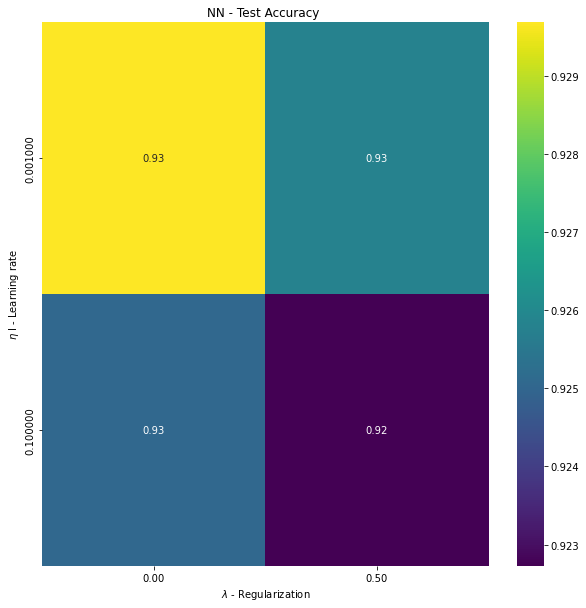

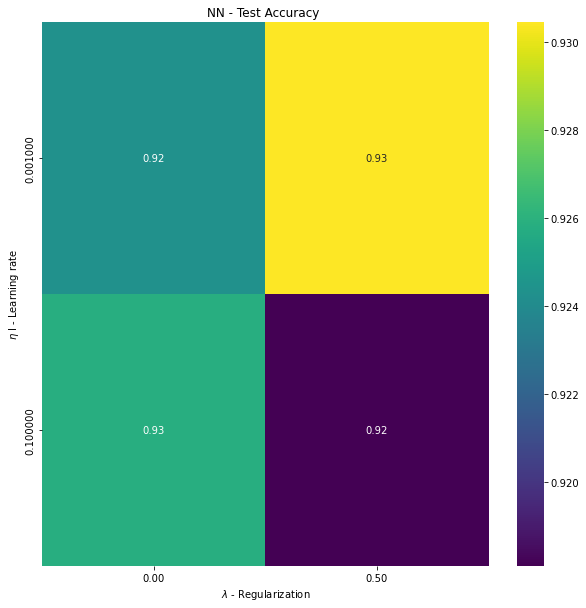

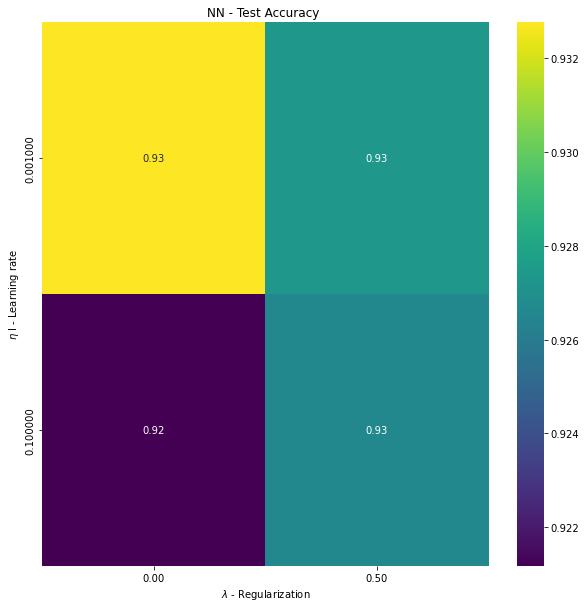

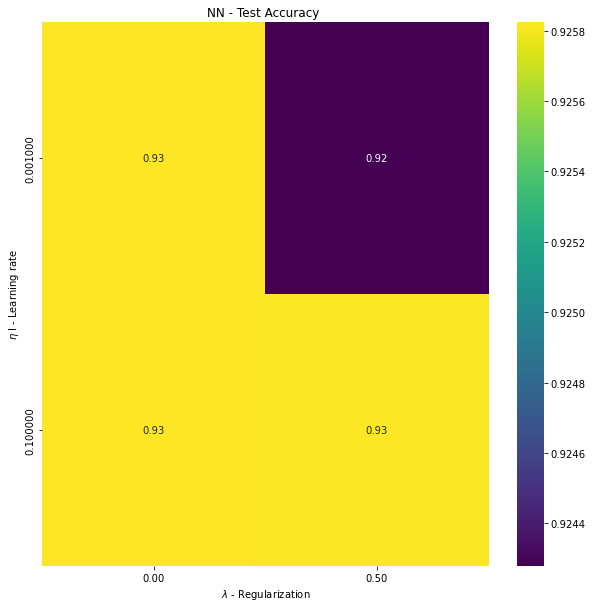

In [7]:
for hidden_l in range(len(hidden_layer_sizes)):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_accuracy_skl[hidden_l, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("NN - Test Accuracy ")
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
    plt.show()

### Study and NN prediction on the validation dataset
Here we train the model on the whole train and test dataset. We then use the optimal hyperparamteres found in the  previous analysis to predtict wet and dry periods on the validation dataset. 

(1536105600.0, 1536624000.0)

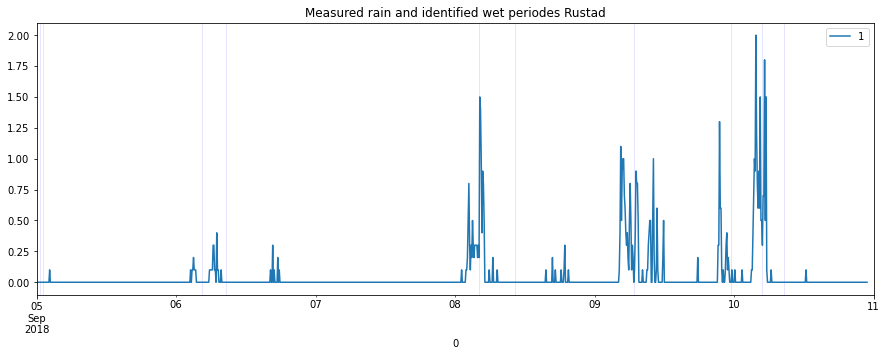

In [79]:
onehot = OneHotEncoder(sparse=False)
learning_rate = 0.1 # initial
regularization = 0

n_epochs = 20000
hidden_layer_sizes = [3, 4]

y_onehot = onehot.fit_transform(y)
n_categories = y_onehot.shape[1]
#dnn = NeuralNetwork(x, y_onehot, n_categories, output_func, eta=learning_rate, 
#                    lmbd=regularization, epochs=n_epochs, batch_size=batch_size, 
#                    activation_func = 'logistic',
#                    hidden_layer_sizes=hidden_layer_sizes)

dnn = MLPClassifier(learning_rate_init=learning_rate, 
                    alpha=regularization, 
                    max_iter=n_epochs, 
                    activation='logistic',
                    solver='lbfgs',
                    verbose = False,
                    hidden_layer_sizes=hidden_layer_sizes)

dnn.fit(x, y_onehot)
dnn_ypred = np.argmax(dnn.predict(x_validation), axis = 1) #de one-hot

#####################################################################

precipitation = pd.DataFrame(np.hstack([t_validation.reshape(-1,1), y_rain_val])).set_index(0)
fig, ax = plt.subplots(figsize = (15, 5))
precipitation.plot(ax=ax)
ax.set_title("Measured rain and identified wet periodes Rustad")

wet_start = []
wet_end = []
# start and end of wet periodes
for i in range(len(dnn_ypred)):
    # start of wet period
    if dnn_ypred[i - 1] == 0 and dnn_ypred[i] != 0:
        wet_start.append(i)
    # start of dry period
    if dnn_ypred[i] != 0 and dnn_ypred[i + 1] == 0:
        wet_end.append(i)

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(wet_start, wet_end):
    ax.axvspan(t_validation[wet_start_i], t_validation[wet_end_i], color='b', alpha=0.1)

ax.set_xlim(pd.Timestamp('2018-09-05'), pd.Timestamp('2018-09-11'))

In [67]:
# med marshal palmer transformering
accuracy_score(y_validation.ravel(), dnn_ypred ) # accuracy score on validation dataset

0.943768115942029

In [132]:
# uten marshal palmer transformeing.. 
accuracy_score(y_validation.ravel(), dnn_ypred ) # accuracy score on validation dataset

0.918722786647315

# Comparing with Logistic regression

In [86]:
from sklearn.linear_model import LogisticRegression
onehot = OneHotEncoder(sparse=False)

regularization = np.array([10000,  10,  5]) #inverse of lambda
k_folds = 5
max_iter = 1000

train_accuracy_lr = np.zeros(len(regularization))
test_accuracy_lr = np.zeros(len(regularization))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

for j in range(len(regularization)):
    R2_test = []
    R2_train = []
    for k in range(k_folds):     
        # extract folds
        xy_test = xy_folds[k].copy() # k-th fold is test 
        xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold
        x_train = xy_train[:, 0:-1]
        y_train = xy_train[:, -1].reshape(-1, 1)
        x_test = xy_test[:, 0:-1]
        y_test = xy_test[:, -1].reshape(-1, 1)   
            
        clf = LogisticRegression(penalty='l2',
                                 C = regularization[j], 
                                 multi_class = 'multinomial', #cross entropy cost function
                                 max_iter = max_iter) 
          
        clf.fit(x_train, y_train.ravel() )
        LR_predict_test = clf.predict(x_test)
        LR_predict_train = clf.predict(x_train)
          
        if not np.isnan(np.sum(LR_predict_test)): 
            R2_test.append( accuracy_score(y_test.ravel(), LR_predict_test.ravel() ))
        if not np.isnan(np.sum(LR_predict_train)):
            R2_train.append(accuracy_score( y_train.ravel(), LR_predict_train.ravel() )) 

    train_accuracy_lr[j] = np.mean(R2_train)
    test_accuracy_lr[j] = np.mean(R2_test)

In [88]:
train_accuracy_lr

array([0.97594203, 0.97594203, 0.97594203])

### Logistic regression prediction on the validation dataset
Here we train the model on the whole train and test dataset. We then use the optimal hyperparamteres found in the  previous analysis to predtict wet and dry periods on the validation dataset. 

(1536105600.0, 1536624000.0)

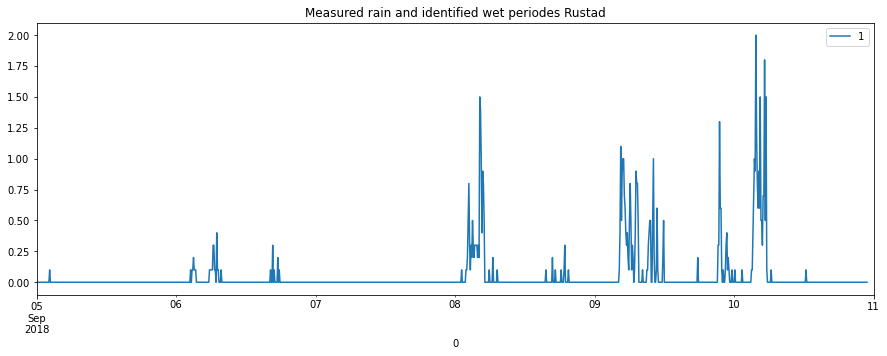

In [89]:
onehot = OneHotEncoder(sparse=False)
batch_size = 64
learning_rate = 0.1 # optimal learning rate
regularization = 10


batch_size = 32
n_epochs = 200

y_onehot = onehot.fit_transform(y)
n_categories = y_onehot.shape[1]

clf = LogisticRegression(penalty='l2',
                         C = regularization, 
                         multi_class = 'multinomial', #cross entropy cost function
                         max_iter = max_iter) 

clf.fit(x, y.ravel())   
LR_predict = clf.predict(x_validation)

precipitation = pd.DataFrame(np.hstack([t_validation.reshape(-1,1), y_rain_val])).set_index(0)
fig, ax = plt.subplots(figsize = (15, 5))
precipitation.plot(ax=ax)
ax.set_title("Measured rain and identified wet periodes Rustad")

wet_start = []
wet_end = []
# start and end of wet periodes
for i in range(len(dnn_ypred)):
    # start of wet period
    if LR_predict[i - 1] == 0 and LR_predict[i] != 0:
        wet_start.append(i)
    # start of dry period
    if LR_predict[i] != 0 and LR_predict[i + 1] == 0:
        wet_end.append(i)

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(wet_start, wet_end):
    ax.axvspan(t_validation[wet_start_i], t_validation[wet_end_i], color='b', alpha=0.1)

ax.set_xlim(pd.Timestamp('2018-09-05'), pd.Timestamp('2018-09-11'))
